# iBKH 驱动的特征选择 + PC DAG

从 iBKH 高血压子图中选择与 MIMIC 对齐的特征，然后在 MIMIC cohort 中抽取对应列，跑 PC 算法得到候选因果结构。


In [1]:
from htn_mimic import build_htn_icu_cohort
from htn_ibkh import extract_htn_ibkh_subgraph, align_ibkh_to_mimic
import pandas as pd

# 1) 构建 MIMIC 高血压 ICU 宽表
cohort = build_htn_icu_cohort()
print("cohort shape:", cohort.shape)

# 2) 从 iBKH 抽取高血压子图，并与 cohort 列对齐
nodes_ibkh, edges_ibkh = extract_htn_ibkh_subgraph()
alignment = align_ibkh_to_mimic(nodes_ibkh, cohort_columns=cohort.columns)

alignment


e:\PHD\01\htn_mimic.py:21: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv(


cohort shape: (64011, 22)


{'exposures': [{'id': 'DrugBank:DB01029',
   'name': 'Irbesartan',
   'maps_to': 'arb_exposed'},
  {'id': 'DrugBank:DB00492', 'name': 'Fosinopril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00876', 'name': 'Eprosartan', 'maps_to': 'arb_exposed'},
  {'id': 'DrugBank:DB00178', 'name': 'Ramipril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00691', 'name': 'Moexipril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00678', 'name': 'Losartan', 'maps_to': 'arb_exposed'},
  {'id': 'DrugBank:DB01197', 'name': 'Captopril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00177', 'name': 'Valsartan', 'maps_to': 'arb_exposed'},
  {'id': 'DrugBank:DB00881', 'name': 'Quinapril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00584', 'name': 'Enalapril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00519',
   'name': 'Trandolapril',
   'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00722', 'name': 'Lisinopril', 'maps_to': 'acei_exposed'},
  {'id': 'DrugBank:DB00542', 'name': '

In [2]:
# 根据 iBKH 对齐结果构造特征列集合

exposure_cols = sorted({a["maps_to"] for a in alignment["exposures"]})
risk_cols     = sorted({a["maps_to"] for a in alignment["risks"]})
outcome_cols  = sorted({a["maps_to"] for a in alignment["outcomes"]})

# 必选的背景协变量
base_cols = ["age", "sex"]

feature_cols = base_cols + sorted(set(exposure_cols + risk_cols + outcome_cols))

print("exposures from iBKH:", exposure_cols)
print("risks from iBKH:", risk_cols)
print("outcomes from iBKH:", outcome_cols)
print("all feature cols:", feature_cols)


exposures from iBKH: ['acei_exposed', 'arb_exposed']
risks from iBKH: ['bmi_omr', 'creatinine_baseline', 'glucose_baseline']
outcomes from iBKH: []
all feature cols: ['age', 'sex', 'acei_exposed', 'arb_exposed', 'bmi_omr', 'creatinine_baseline', 'glucose_baseline']


In [3]:
# 构造用于 PC 的数据集

df = cohort[feature_cols].copy()

# 将 sex 转成 0/1
df["sex_female"] = (df["sex"] == "F").astype(int)
df = df.drop(columns=["sex"])

# PC 目前简单地直接丢掉含缺失值的样本
df_pc = df.dropna().copy()
print("df_pc shape:", df_pc.shape)
df_pc.head()


df_pc shape: (29837, 7)


,age,acei_exposed,arb_exposed,bmi_omr,creatinine_baseline,glucose_baseline,sex_female
0,86,0,0,23.0,0.9,77.0,1
1,73,1,0,31.8,2.2,144.0,1
4,73,0,0,30.6,1.3,133.0,0
5,68,0,0,27.7,1.1,148.0,1
6,53,0,0,39.3,1.1,216.0,1


In [6]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from causallearn.graph.Endpoint import Endpoint

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# 运行 PC 算法
data = df_pc.values
cg = pc(data, alpha=0.05, indep_test=fisherz)

cols_pc = df_pc.columns.tolist()

# 把 PC 图里的节点名映射回列名
nodes_pc = cg.G.get_nodes()
name_to_col = {node.get_name(): cols_pc[i] for i, node in enumerate(nodes_pc)}

edges_named = []
for e in cg.G.get_graph_edges():
    n1_name = name_to_col.get(e.get_node1().get_name())
    n2_name = name_to_col.get(e.get_node2().get_name())
    if n1_name is None or n2_name is None:
        continue

    ep1 = e.get_endpoint1()
    ep2 = e.get_endpoint2()

    if ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:      # n1 -> n2
        edges_named.append((n1_name, n2_name))
    elif ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:    # n2 -> n1
        edges_named.append((n2_name, n1_name))

edges_named = list(set(edges_named))
print("num directed edges (raw PC):", len(edges_named))

# 在 iBKH-PC 图上强制 age / sex_female 只作为起点，hospital_mortality 只作为终点
roots = {"age", "sex_female"}
sinks = {"hospital_mortality"}

def _apply_direction_constraints(src: str, dst: str):
    """根据 root / sink 约束决定边的方向，必要时翻转或丢弃。"""
    # 如果 src 是 sink，或者 dst 是 root，则当前方向不允许
    if src in sinks or dst in roots:
        # 尝试翻转方向
        rev_src, rev_dst = dst, src
        # 翻转后如果仍然违反约束，就完全丢弃这条边
        if rev_src in sinks or rev_dst in roots:
            return None
        return rev_src, rev_dst
    return src, dst

edges_adjusted = []
for src, dst in edges_named:
    adjusted = _apply_direction_constraints(src, dst)
    if adjusted is None:
        continue
    edges_adjusted.append(adjusted)

# 去重，保持顺序
seen = set()
edges_rooted = []
for e in edges_adjusted:
    if e not in seen:
        seen.add(e)
        edges_rooted.append(e)

# 简单打印一下新的源点 / 终点检查约束是否生效
nodes_all = set()
for s, d in edges_rooted:
    nodes_all.add(s)
    nodes_all.add(d)

indeg = defaultdict(int)
outdeg = defaultdict(int)
for n in nodes_all:
    indeg[n] = 0
    outdeg[n] = 0
for s, d in edges_rooted:
    outdeg[s] += 1
    indeg[d] += 1

print("num directed edges (after constraints):", len(edges_rooted))
print("sources (indegree 0):", [n for n in nodes_all if indeg[n] == 0])
print("sinks (outdegree 0):", [n for n in nodes_all if outdeg[n] == 0])


Depth=4, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 1399.97it/s]

num directed edges (raw PC): 11
num directed edges (after constraints): 10
sources (indegree 0): ['age', 'sex_female', 'acei_exposed']
sinks (outdegree 0): ['creatinine_baseline']


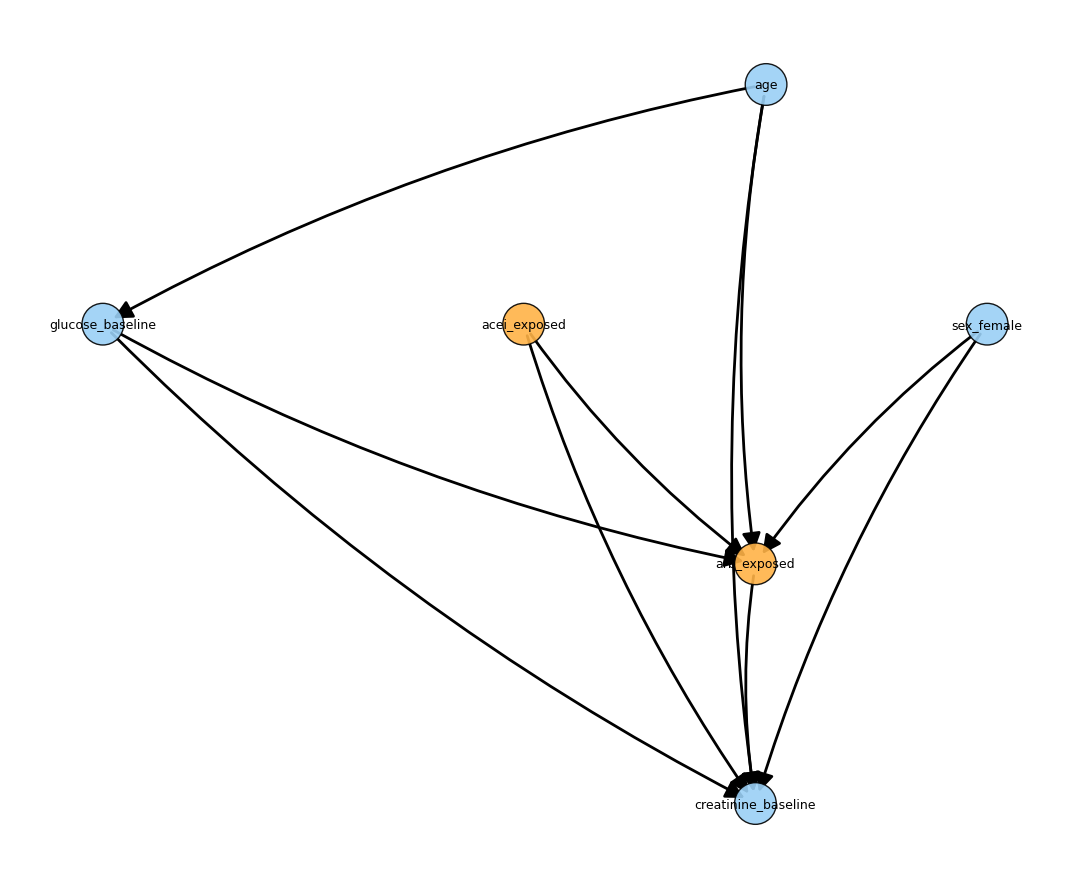

In [9]:
# 用 iBKH 驱动的分组画出 PC 学到的有向图（增强箭头可见性）
exposure_set = set(exposure_cols)
outcome_set = set(outcome_cols)
G_nx = nx.DiGraph()
G_nx.add_edges_from(edges_rooted)
node_colors = []
color_map = {"exposure": "#ffb347", "outcome": "#ff6b6b", "other": "#9ad0f5"}
for n in G_nx.nodes:
    if n in exposure_set:
        node_colors.append(color_map["exposure"])
    elif n in outcome_set:
        node_colors.append(color_map["outcome"])
    else:
        node_colors.append(color_map["other"])
# 优先使用 graphviz 的层次布局，让箭头方向更直观
try:
    from networkx.drawing.nx_pydot import graphviz_layout
    pos = graphviz_layout(G_nx, prog="dot")
except Exception:
    pos = nx.spring_layout(G_nx, seed=42, k=0.6)
plt.figure(figsize=(11, 9))
# 先画边，再画节点，这样箭头不会完全被圆盖住
nx.draw_networkx_edges(
    G_nx,
    pos,
    arrowstyle="-|>",
    arrows=True,
    arrowsize=28,
    width=2.0,
    connectionstyle="arc3,rad=0.08",
)
nx.draw_networkx_nodes(
    G_nx,
    pos,
    node_color=node_colors,
    node_size=900,
    edgecolors="black",
    alpha=0.9,
)
nx.draw_networkx_labels(G_nx, pos, font_size=9)
plt.axis("off")
plt.tight_layout()
plt.show()
